# Desafio
Dataset com 7121 formulas de medicamentos manipulados.  
O objetivo do teste é prever o valor da coluna "correto" com menor erro possível a partir das outras informações do dataset.  
dos 7121 pontos de dados, pode-se usar no máximo os primeiros 5121 dados do dataset para prever os últimos 2000  

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
from collections import Counter
import datetime
import time
import multiprocessing as mp
print('Threads on this machine:', mp.cpu_count())
import sklearn

Threads on this machine: 8


## Load Data

In [2]:
# Carrega o dataset
df = pd.read_csv('https://raw.githubusercontent.com/manipulaeHealth/desafio-machine-learning/main/dados_preco.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7121 entries, 0 to 7120
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   descricao   7121 non-null   object 
 1   criado      7121 non-null   object 
 2   qtdInsumos  7121 non-null   int64  
 3   calculado   7121 non-null   float64
 4   correto     7121 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 278.3+ KB


## Transformação e limpza dos dados

In [4]:
df['criado'] = pd.to_datetime(df.criado)

In [5]:
# Isola a quantidade de capsulas
df['cap'] = [int(x[0]) for x in df.descricao.str.split(' ', 1)]

In [6]:
df['ins'] = [x[1] for x in df.descricao.str.split('|')]

In [7]:
df_ins = df['ins'].apply(lambda x: x.split(';')).apply(pd.Series)

In [8]:
df_ins = df_ins.rename(columns = lambda x: 'ins_' + str(x))

In [9]:
df.drop('descricao', inplace=True, axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7121 entries, 0 to 7120
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   criado      7121 non-null   datetime64[ns]
 1   qtdInsumos  7121 non-null   int64         
 2   calculado   7121 non-null   float64       
 3   correto     7121 non-null   float64       
 4   cap         7121 non-null   int64         
 5   ins         7121 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 333.9+ KB


In [11]:
df

,criado,qtdInsumos,calculado,correto,cap,ins
0,2020-08-05 23:19:09,1,47.5297,39.9,30,BUPROPIONA CLORIDRATO 150MG
1,2020-08-05 22:51:09,1,46.9620,43.6,60,FINASTERIDA 1:10 1MG
2,2020-08-05 22:51:09,3,105.1390,111.4,60,NAC 250MG; SILIMARINA 150MG; SAME 50MG
3,2020-08-05 22:51:09,1,49.0314,43.6,60,ANASTROZOL 1:10 0.300MG
4,2020-08-05 22:49:09,2,161.8272,146.0,120,DUTASTERIDA 0.250MG; TADALAFIL 10MG
...,...,...,...,...,...,...
7116,2020-07-09 17:33:11,12,188.5325,181.8,45,SERTRALINA CLORIDRATO 40MG; SLENDESTA 75MG;...
7117,2020-07-09 17:24:09,1,377.6529,346.6,120,GREENSELECT 120MG
7118,2020-07-09 17:23:10,11,166.2868,157.2,60,MAGNESIO QUELADO 30% 220MG; SELENIO QUELADO ...
7119,2020-07-09 17:22:09,3,60.1646,68.1,30,VALERIANA 50MG; PASSIFLORA 500MG; CAMOMILA ...


## Análise Exploratória 1
### Existe correlação entre a data e o preço?

In [12]:
df1 = df.copy()

In [13]:
df1['mes'] = df1.criado.dt.month
df1['dia'] = df1.criado.dt.day
df1['hora'] = df1.criado.dt.hour

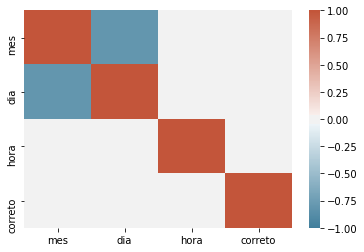

In [14]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df1[['mes', 'dia', 'hora', 'correto']].corr(), vmax=1, vmin=-1, cmap=cmap);

**Não há correlação significativa para considerar a coluna com a timestamp de criação da fórmula**

In [15]:
df.drop('criado', axis=1, inplace=True)

## Analise exploratoria 2
Extração dos insumos e respectivas quantidades

In [16]:
df

,qtdInsumos,calculado,correto,cap,ins
0,1,47.5297,39.9,30,BUPROPIONA CLORIDRATO 150MG
1,1,46.9620,43.6,60,FINASTERIDA 1:10 1MG
2,3,105.1390,111.4,60,NAC 250MG; SILIMARINA 150MG; SAME 50MG
3,1,49.0314,43.6,60,ANASTROZOL 1:10 0.300MG
4,2,161.8272,146.0,120,DUTASTERIDA 0.250MG; TADALAFIL 10MG
...,...,...,...,...,...
7116,12,188.5325,181.8,45,SERTRALINA CLORIDRATO 40MG; SLENDESTA 75MG;...
7117,1,377.6529,346.6,120,GREENSELECT 120MG
7118,11,166.2868,157.2,60,MAGNESIO QUELADO 30% 220MG; SELENIO QUELADO ...
7119,3,60.1646,68.1,30,VALERIANA 50MG; PASSIFLORA 500MG; CAMOMILA ...


In [17]:
print('Total de insumos: ',df.qtdInsumos.sum())

Total de insumos:  23370


In [18]:
quantities = []

#for intens in supplies
for itens in df.ins.str.split(';'):
    
    # isolate each quantitie
    for item in itens:

        # Regex rule to isolate quantites
        match = re.search(r'(\d*\.\d\w*$)|(\d\w*$)|(\d\w*%$)', item)
#         prop = re.search(r'(\d.\d*%)|(\d*%)|(\d:\d*)', item)

        if match != None:
            quantities.append(match.group())
        else:
            print(item)

In [19]:
quantities[:10]

['150MG',
 '1MG',
 '250MG',
 '150MG',
 '50MG',
 '0.300MG',
 '0.250MG',
 '10MG',
 '12MCG',
 '60MCG']

Extração todas as quantidades com unidades de medida

In [20]:
#Test
len(quantities) == df.qtdInsumos.sum()

True

In [21]:
units = []

for unit in quantities:
    
    # Regex to isolate units 
    match = re.search(r'\D*$', unit)
    
    units.append(match.group())

In [22]:
set(units)

{'%', 'CAP', 'G', 'MCG', 'MG', 'UI', 'UI%', 'UN', 'UTR'}

In [23]:
#Teste
len(units) == df.qtdInsumos.sum()

True

Estão presentes diferentes unidades de medidas farmacêuticas.  
Caso o modelo apresentar problemas de performance, pode-se trabalhar em normalizar as quantidades para extrair features

In [24]:
supplies =[]

for itens in df.ins.str.split(';'):
    for item in itens:
        
        #Regex to isolate supplie
        match = re.findall(r'([a-zA-Z_][-a-zA-Z0-9_]*)\s', item)
    
        supplies.append(' '.join(match))

In [25]:
len(supplies) == df.qtdInsumos.sum()

True

In [26]:
supplies[:10]

['BUPROPIONA CLORIDRATO',
 'FINASTERIDA',
 'NAC',
 'SILIMARINA',
 'SAME',
 'ANASTROZOL',
 'DUTASTERIDA',
 'TADALAFIL',
 'TRIIODOTIRONINA SLOW RELEASE',
 'T4']

### Top 10 insumos que mais aparecem em receitas

In [27]:
# "Map-reduce"

dict(Counter(supplies))
sort_orders = sorted(dict(Counter(supplies)).items(), key=lambda x: x[1], reverse=True);
sort_orders[:10]

[('ZINCO QUELADO', 462),
 ('VITAMINA D3', 369),
 ('VITAMINA K2 MK7', 336),
 ('SELENIO QUELADO', 320),
 ('BIOTINA', 314),
 ('METILFOLATO', 307),
 ('VITAMINA D', 293),
 ('MAGNESIO DIMALATO', 288),
 ('VITAMINA D LIQ CAP ATE MIL', 277),
 ('METILCOBALAMINA', 276)]

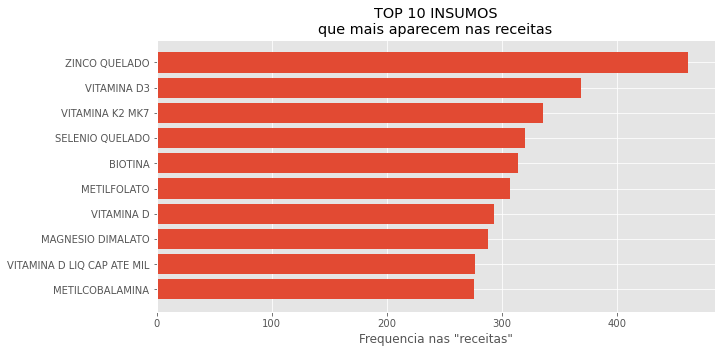

In [28]:
x_axis = [x[0] for x in sort_orders[:10]][::-1]
y_axis = [x[1] for x in sort_orders[:10]][::-1]


plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,5))

ax.barh(x_axis, y_axis)
plt.title('TOP 10 INSUMOS\nque mais aparecem nas receitas')
ax.set_xlabel('Frequencia nas "receitas"');

# Modelo base

Prever variável quantitativa -> Modelos de Regressão

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

In [30]:
df2 = df.copy()

In [31]:
df2.columns = ['qtd', 'calc', 'target', 'cap', 'ins']
df2 = df2[['qtd', 'calc', 'cap', 'target']]

In [32]:
print(df2.head())
print(len(df2), 'rows')

   qtd      calc  cap  target
0    1   47.5297   30    39.9
1    1   46.9620   60    43.6
2    3  105.1390   60   111.4
3    1   49.0314   60    43.6
4    2  161.8272  120   146.0
7121 rows


In [33]:
X_train, Y_train = df2.iloc[:5121, :-1], df2.iloc[:5121, -1]
X_test, Y_test = df2.iloc[5121:, :-1], df2.iloc[5121:, -1]

model1 = LinearRegression().fit(X_train, Y_train)

Y_predict = model1.predict(X_test)

print('R2 Score:', r2_score(Y_test, Y_predict))
print('MAE:', mean_absolute_error(Y_test, Y_predict))

R2 Score: 0.9460758031449517
MAE: 14.318793462208284


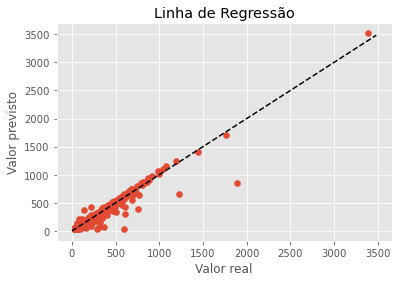

In [34]:
plt.scatter(Y_test, Y_predict)
plt.plot([x for x in range(0, int(max((Y_test)))+100)], color='black', linestyle = '--' )
plt.title('Linha de Regressão')
plt.xlabel('Valor real')
plt.ylabel('Valor previsto');

O modelo base obteve um coeficiente de determinação de 0.946  

### Se considerarmos que o valor predito é igual ao calculado (coluna 'calc') temos o seguinte resultado:

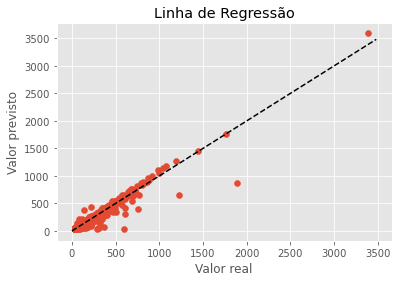

In [35]:
plt.scatter(df2.target[5121:], df2.calc[5121:])
plt.plot([x for x in range(0, int(max((df2.target[5121:])))+100)], color='black', linestyle = '--' )
plt.title('Linha de Regressão')
plt.xlabel('Valor real')
plt.ylabel('Valor previsto');

In [36]:
print('R2 Score:', r2_score(df2.target[5121:], df2.calc[5121:]))

R2 Score: 0.9439626160390919


Assumir que o valor target é igual ao valor calculado mostrou ter uma significancia muito próxima a do modelo treinado. 0.943

# Transformação e limpeza dos dados (parte 2)
## Verificando valores outlier

In [37]:
df3 = df2.copy()

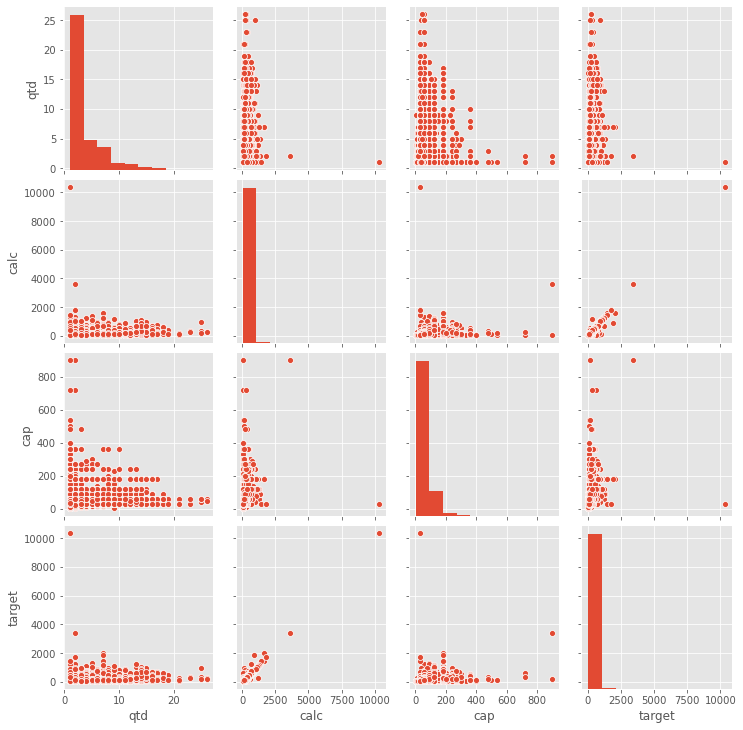

In [38]:
sns.pairplot(df3);

In [39]:
df3.describe()

,qtd,calc,cap,target
count,7121.000000,7121.000000,7121.000000,7121.000000
mean,3.281842,137.089552,68.664935,135.891798
std,3.194301,191.266516,50.442119,189.806974
min,1.000000,30.000100,1.000000,33.000000
25%,1.000000,49.786100,30.000000,49.500000
50%,2.000000,87.350300,60.000000,83.100000
75%,4.000000,165.167000,90.000000,161.200000
max,26.000000,10364.992500,900.000000,10356.000000


Percebe-se que há alguns pontos muito distantes da maioria

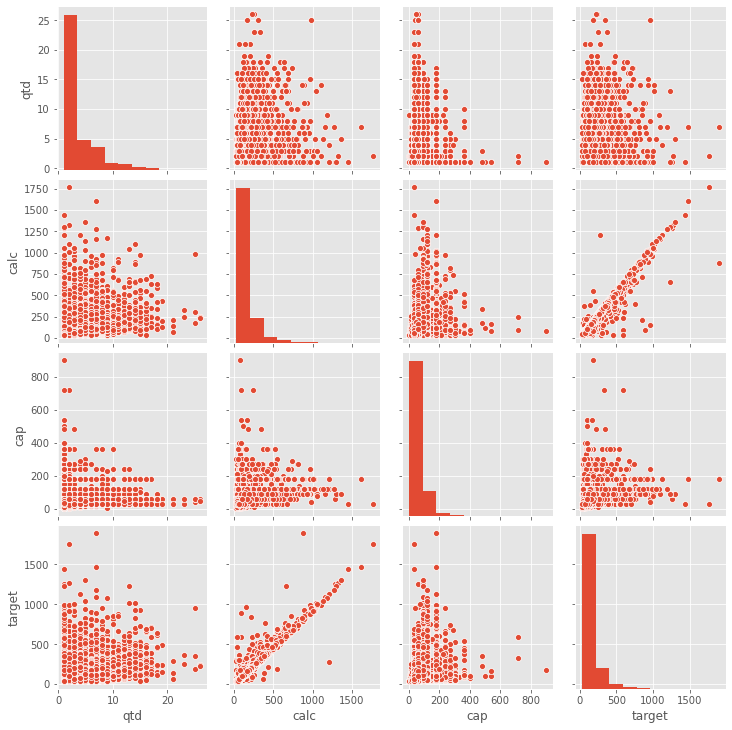

In [40]:
sns.pairplot(df3[~(df3.target > 2000)]);

In [41]:
df3[(df3.target > 2000)]

,qtd,calc,cap,target
1904,7,1612.9217,180,2013.0
2995,1,10364.9925,30,10356.0
6870,2,3594.4275,900,3385.7


In [42]:
df4 = df3[~(df3.target > 2000)]

In [43]:
X_train, Y_train = df4.iloc[:5121, :-1], df4.iloc[:5121, -1]
X_test, Y_test = df4.iloc[5121:, :-1], df4.iloc[5121:, -1]

model2 = LinearRegression().fit(X_train, Y_train)

Y_predict = model2.predict(X_test)

r2_score(Y_test, Y_predict)

0.933027188614508

Removendo os valores outlier, obteve-se um resultado pior do que o modelo base. (Para regressão linear)  
Portanto, para esse modelo mantém-se o valor outlier

## Normalização e Padronização dos dados

In [44]:
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler

In [45]:
df5 = df4.copy() # Without Outliers

In [46]:
df6 = df3.copy() # Full dataset

In [47]:
stand = StandardScaler().fit(df5.iloc[:,:-1])
scaller = MinMaxScaler((0, 10)).fit(df5.iloc[:,:-1])
norm = Normalizer().fit(df5.iloc[:,:-1])

df5.iloc[:,:-1] = scaller.transform(df5.iloc[:,:-1])
df5.iloc[:,:-1] = stand.transform(df5.iloc[:,:-1])

stand = StandardScaler().fit(df6.iloc[:,:-1])
scaller = MinMaxScaler((0, 10)).fit(df6.iloc[:,:-1])
norm = Normalizer().fit(df6.iloc[:,:-1])

df6.iloc[:,:-1] = scaller.transform(df6.iloc[:,:-1])
df6.iloc[:,:-1] = stand.transform(df6.iloc[:,:-1])

# Testando outros modelos

In [48]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score

In [49]:
def alternative_models(dataframe, models: list):
    """
    A partir do dataframe, com a variavel target na última coluna
    testa outros modelos.
    """
    result_df = pd.DataFrame()
    X_train, Y_train = dataframe.iloc[:5121, :-1], dataframe.iloc[:5121, -1]
    X_test, Y_test = dataframe.iloc[5121:, :-1], dataframe.iloc[5121:, -1]
    print('R2 Score:')
    for model in models:
        mod = model.fit(X_train, Y_train)
        scores = cross_val_score(mod, X_train, Y_train, cv=10)
        Y_predict = mod.predict(X_test)
        result_df[type(mod).__name__] = scores
        print(type(mod).__name__, r2_score(Y_test, Y_predict), '\n')
    result_df.boxplot(figsize=(25,5))
    plt.xticks(rotation=45)
    plt.title('Intervalo de confiança')

R2 Score:
DecisionTreeRegressor 0.8850431621542381 

AdaBoostRegressor 0.8557895800244519 

GradientBoostingRegressor 0.8890025983752081 

RandomForestRegressor 0.8912330681126357 

MLPRegressor 0.9465315034232744 

LinearRegression 0.9460758031449517 



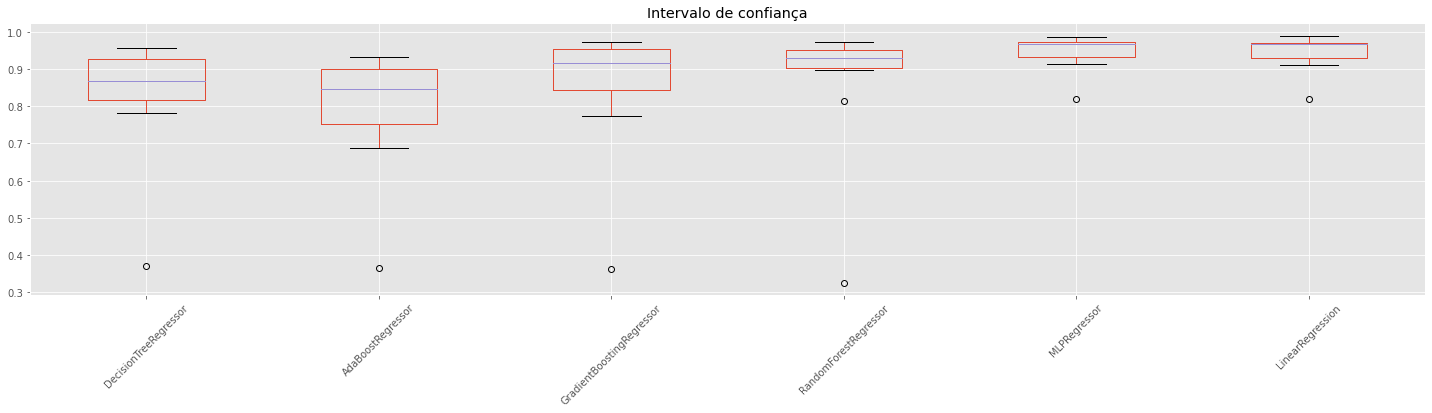

In [50]:
alternative_models(df3, [DecisionTreeRegressor(random_state=3),
                        AdaBoostRegressor(random_state=3, n_estimators=20),
                        GradientBoostingRegressor(random_state=3, n_estimators=1000),
                        RandomForestRegressor(random_state=3),
                        MLPRegressor(max_iter=5000, random_state=3),
                        LinearRegression()])

R2 Score:
DecisionTreeRegressor 0.899423066663018 

AdaBoostRegressor 0.822573190344458 

GradientBoostingRegressor 0.9151230470450201 

RandomForestRegressor 0.9222187604169195 

MLPRegressor 0.934226998227644 

LinearRegression 0.933027188614508 



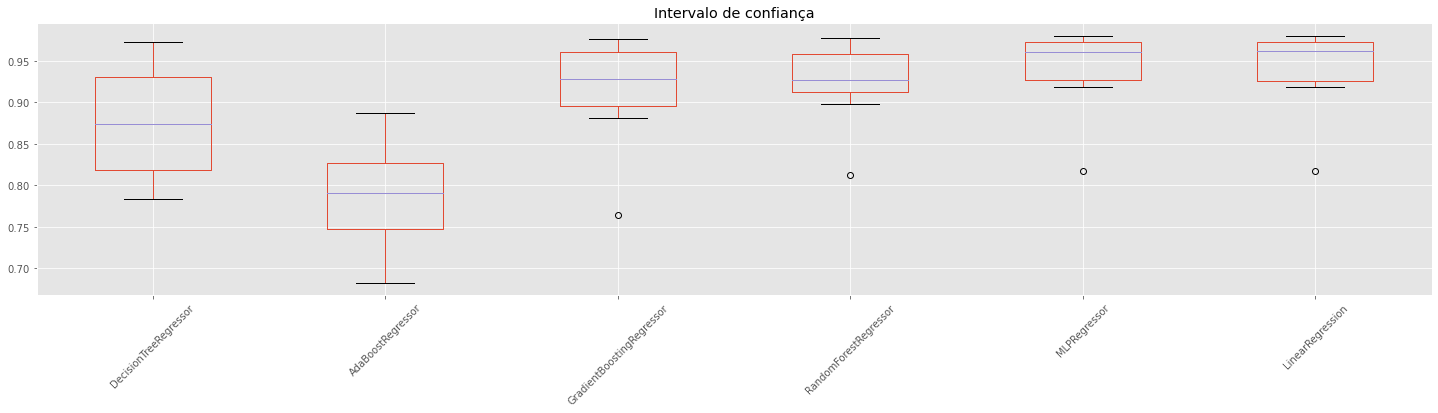

In [51]:
alternative_models(df4, [DecisionTreeRegressor(random_state=3),
                        AdaBoostRegressor(random_state=3, n_estimators=20),
                        GradientBoostingRegressor(random_state=3, n_estimators=1000),
                        RandomForestRegressor(random_state=3),
                        MLPRegressor(max_iter=5000),
                        LinearRegression()])

R2 Score:
DecisionTreeRegressor 0.9022288634164827 

AdaBoostRegressor 0.822573190344458 

GradientBoostingRegressor 0.91938311310172 

RandomForestRegressor 0.9228717910549007 

LinearRegression 0.9330271886145076 



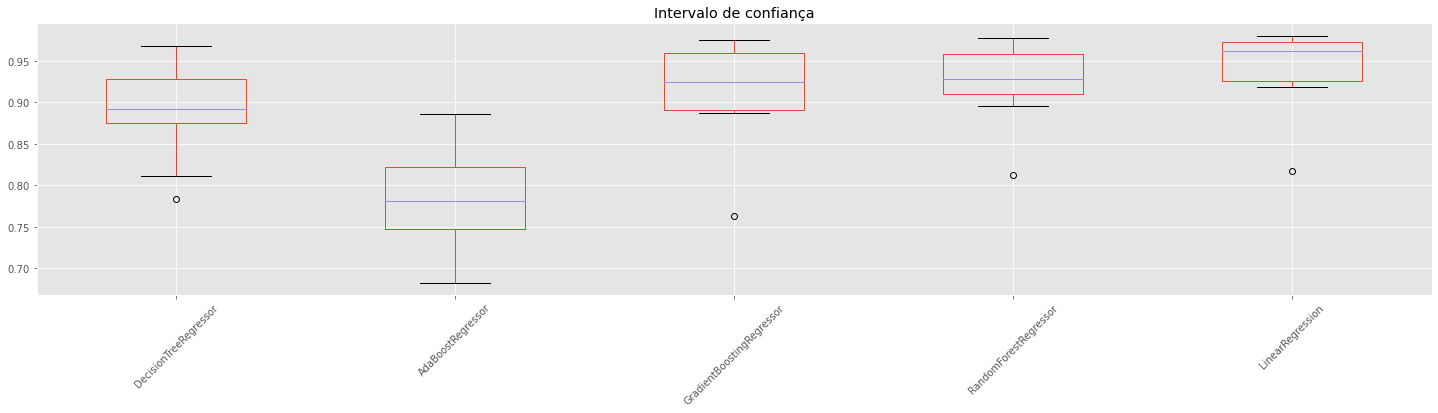

In [52]:
alternative_models(df5, [DecisionTreeRegressor(random_state=3),
                        AdaBoostRegressor(random_state=3, n_estimators=20),
                        GradientBoostingRegressor(random_state=3, n_estimators=1000),
                        RandomForestRegressor(random_state=3),
                        LinearRegression()])

R2 Score:
DecisionTreeRegressor 0.8890512570968233 

AdaBoostRegressor 0.8700327582469267 

GradientBoostingRegressor 0.8913316877649555 

RandomForestRegressor 0.8927299539517481 



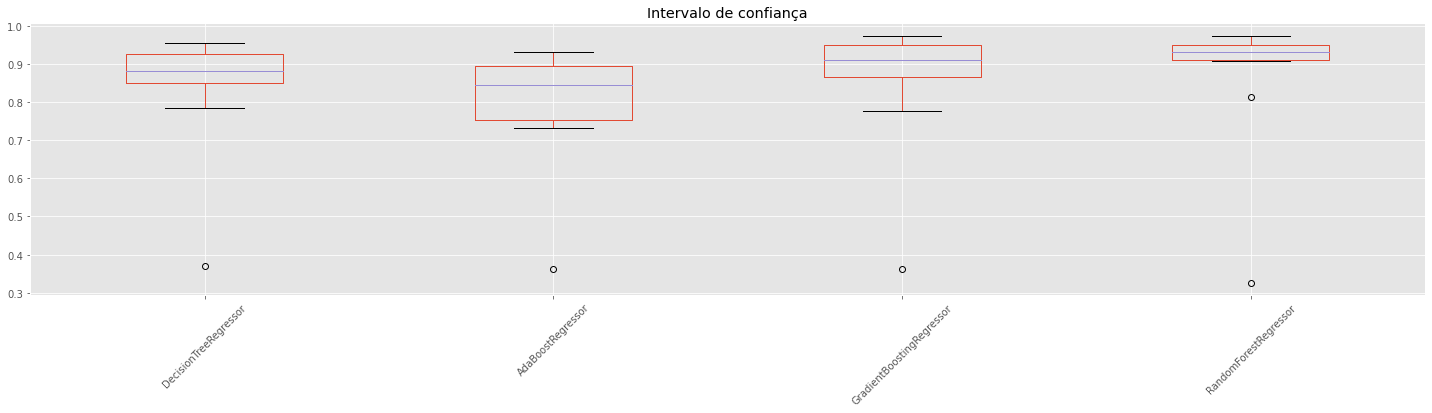

In [53]:
alternative_models(df6, [DecisionTreeRegressor(random_state=3),
                        AdaBoostRegressor(random_state=3, n_estimators=20),
                        GradientBoostingRegressor(random_state=3, n_estimators=1000),
                        RandomForestRegressor(random_state=3)])

## Resumo:

- Assumir o valor calculado como preço final tem um coeficiente de determinação aceitável
- O modelo de regressão linear é um modelo simples e tem um resultado levemente melhor
- O modelo com rede neural (Multi-layer Perceptron regressor) teve o melhor resultado até aqui
  - O modelo foi treinado utilizando os dados sem tratamento
  - Deve-se avaliar o custo para o modelo (treinamento/produção) pois a melhora em relação a regeressáo linear é pequena, portanto, a utilização deve ser bem justificada.

## Feature Engineering

Qual insumo tem a maior correlação com a variável alvo?

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

In [55]:
df7 = df.copy()
df7.columns = ['qtd', 'calc', 'target', 'cap', 'ins']
df7

,qtd,calc,target,cap,ins
0,1,47.5297,39.9,30,BUPROPIONA CLORIDRATO 150MG
1,1,46.9620,43.6,60,FINASTERIDA 1:10 1MG
2,3,105.1390,111.4,60,NAC 250MG; SILIMARINA 150MG; SAME 50MG
3,1,49.0314,43.6,60,ANASTROZOL 1:10 0.300MG
4,2,161.8272,146.0,120,DUTASTERIDA 0.250MG; TADALAFIL 10MG
...,...,...,...,...,...
7116,12,188.5325,181.8,45,SERTRALINA CLORIDRATO 40MG; SLENDESTA 75MG;...
7117,1,377.6529,346.6,120,GREENSELECT 120MG
7118,11,166.2868,157.2,60,MAGNESIO QUELADO 30% 220MG; SELENIO QUELADO ...
7119,3,60.1646,68.1,30,VALERIANA 50MG; PASSIFLORA 500MG; CAMOMILA ...


In [56]:
supps = [x[0] for x in sort_orders]

In [57]:
supps[:5]

['ZINCO QUELADO',
 'VITAMINA D3',
 'VITAMINA K2 MK7',
 'SELENIO QUELADO',
 'BIOTINA']

In [58]:
#### SINGLE THREAD FUNCTION ####

# correlations = []
# for k, n in enumerate(supps):
#     print(len(supps)-k)
#     df['sup'] = 0
#     for i, sup in enumerate(df4.ins.str.split(';')):

#         if any(n in s for s in sup):
#     #         print(i)
#             df4.loc[i, 'sup'] = 1
#         else:
#             df4.loc[i, 'sup'] = 0

#     vc = df[['target', 'sup']].corr().values[0][1]
#     if np.isnan(vc):
#         vc = 0
#     correlations.append([n, vc])

In [59]:
#### MULTI-THREAD ####
manager = mp.Manager()
shared_correlations1 = manager.list()
def find_corr(supp):
    print('.', end='')
    dd = df7.copy()
    dd['sup'] = 0
    for i, sup in enumerate(dd.ins.str.split(';')):

        if any(supp in s for s in sup):
    #         print(i)
            dd.loc[i, 'sup'] = 1
        else:
            dd.loc[i, 'sup'] = 0

    vc = dd[['target', 'sup']].corr().values[0][1]
    if np.isnan(vc):
        vc = 0
    shared_correlations1.append([supp, vc])
    

In [ ]:
init = datetime.datetime.now()
with mp.Pool(mp.cpu_count()) as p:
    p.map(find_corr, supps)
    time.sleep(3)
    p.terminate()
    time.sleep(3)
    p.join()
    time.sleep(3)
    p.close()
    del p
final = datetime.datetime.now() - init
print('\n\nFinished with:', final)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
sorted(shared_correlations1, key=lambda x: x[1], reverse=True)[:10]

In [ ]:
sorted(shared_correlations1, key=lambda x: x[1], reverse=True)[-10:]

A presença de ANDARINA parece ter uma correlação significativa com a variável alvo

In [ ]:
corpus = df.ins.values.tolist()

In [ ]:
supps[:5]

In [ ]:
vocabulary = supps[:5] # Teste com os 7 que mais aparecem

In [ ]:
vocabulary.append('ANDARINA')
vocabulary.append('PIMENTAR PRETA')

In [ ]:
vocabulary

In [ ]:
vectorizer = CountVectorizer(vocabulary=vocabulary,
                             lowercase=False,
                            ngram_range=(1,3))
vectorizer.fit_transform(corpus).toarray()

In [ ]:
sup_df = pd.DataFrame(vectorizer.fit_transform(corpus).toarray(),
             columns=['zq', 'vd3', 'vk2', 'sq', 'bio', 'and', 'pim'])

In [ ]:
df7 = pd.concat([df7, sup_df], axis=1)
df7 = df7[['qtd', 'calc', 'cap', 'zq', 'vd3', 'vk2', 'sq', 'bio', 'and', 'pim', 'target']]

In [ ]:
df7

In [ ]:
sns.heatmap(df7.corr(), cmap=cmap, vmin=-1, vmax=1);

In [ ]:
alternative_models(df7, [DecisionTreeRegressor(random_state=3),
                        AdaBoostRegressor(random_state=3, n_estimators=20),
                        GradientBoostingRegressor(random_state=3, n_estimators=1000),
                        RandomForestRegressor(random_state=3),
                        MLPRegressor(max_iter=5000, random_state=3),
                        LinearRegression()])

## Conclusão

- Realizando engenharia de atributos percebe-se que o modelo de Regressão Linear obteve o melhor resultado com um intervalo de confiança semelhante a rede neural.
  - LinearRegression --> R2 = 0.9475471582696882